# Group 11

## Iben Mai Huse, Karlis Buiko, Markus Sibbesen, Ida Kathrine Jensen

This notebook contains the code for data exploration, and will be the hand-in for the First Year Project 4

Created 04.05.2021

Last modified, modified by:

02.06.2021, all

### Imports

In [1]:
import pandas as pd 
import numpy as np
import csv 
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import TweetTokenizer
from difflib import ndiff
from collections import Counter
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
## True if you want to reprocess tokenization from original data

preprocess = False

### Path to files

In [3]:
if preprocess:
    # For hate speech detection
    hate_train = open("datasets/hate/train_text.txt", "r", encoding="utf-8").read()
    hate_test = open("datasets/hate/test_text.txt", "r", encoding="utf-8").read()
    hate_mapping = open("datasets/hate/mapping.txt", "r", encoding="utf-8").read()

    hate_train_labels = open("datasets/hate/train_labels.txt", "r", encoding="utf-8").read()
    hate_test_labels = open("datasets/hate/test_labels.txt", "r", encoding="utf-8").read()


    # For sentiment analysis
    sentiment_train = open("datasets/sentiment/train_text.txt", "r", encoding="utf-8").read()
    sentiment_test = open("datasets/sentiment/test_text.txt", "r", encoding="utf-8").read()
    sentiment_mapping = open("datasets/sentiment/mapping.txt", "r", encoding="utf-8").read()

    sentiment_train_labels = open("datasets/sentiment/train_labels.txt", "r", encoding="utf-8").read()
    sentiment_test_labels = open("datasets/sentiment/test_labels.txt", "r", encoding="utf-8").read()


## Task 1: Preprocessing

#### We have selected *hate speech detection* as the binary classifier and the *sentiment analysis* as the multiclass classifier.

*Using regular expressions, implement a tokeniser to split the input texts into meaningful tokens. Your tokeniser should be a script that takes as input the data as distributed in the dataset and outputs the tokenised text, one output line per input line, with spaces between tokens.*

*• Use the training set of one of the tasks you’ve chosen to work on. Set aside a part of the training set for evaluating the tokeniser so you don’t have to touch the validation data for that.*

In [4]:
if preprocess:
    hate_train_lists = hate_train.strip().split('\n')
    hate_train_tokenize = hate_train_lists[0:4500]
    hate_train_set_aside = hate_train_lists[4500:-1]

*• Start by taking a subset of the trainingdata, look through it and discuss in your group what a good tokenisation of this subset should look like. Then design your initial Python implementation to match this ideal tokenisation, and run it over the portion of the training set that you didn’t hold out for tokeniser evaluation. Keep an eye on infrequently occurring tokens in the output that look like tokenisation errors.*

In [5]:
def tokenize_line(line):
    #replacements = ".,:;?!/#%\(\)@$\-…"
    #temp = re.sub(f'([^ ])([{replacements}])', r'\1 \2', line)
    #temp = re.sub(f'([{replacements}])([^ ])', r'\1 \2', temp)
    #temp = re.sub(f'([a-zA-Z])([^a-zA-Z ])', r'\1 \2', line)
    #temp = re.sub(f'([^a-zA-Z @#])([a-zA-Z])', r'\1 \2', temp)
    temp = re.sub(f'(\w)([^\w ])', r'\1 \2', line)
    temp = re.sub(f'([^\w @#])(\w)', r'\1 \2', temp)
    return temp.strip(' ').split(' ')

def tokenize_line_str(line):
    #replacements = ".,:;?!/#%\(\)@$\-…"
    #temp = re.sub(f'([^ ])([{replacements}])', r'\1 \2', line)
    #temp = re.sub(f'([{replacements}])([^ ])', r'\1 \2', temp)
    #temp = re.sub(f'([a-zA-Z])([^a-zA-Z ])', r'\1 \2', line)
    #temp = re.sub(f'([^a-zA-Z @#])([a-zA-Z])', r'\1 \2', temp)
    temp = re.sub(f'(\w)([^\w ])', r'\1 \2', line)
    temp = re.sub(f'([^\w @#])(\w)', r'\1 \2', temp)
    return temp

tokenize_line('hej, d/et.te (er) en .teås\t99! \ g')

['hej',
 ',',
 'd',
 '/',
 'et',
 '.',
 'te',
 '(',
 'er',
 ')',
 'en',
 '.',
 'teås',
 '\t',
 '99',
 '!',
 '\\',
 'g']

*• Once you’re done, compare your tokeniser’s output with the baseline tokenisation
you get from the social media tokeniser in the NLTK library (nltk.tokenize.TweetTokenizer), using the data you’ve set aside for this purpose.*

In [6]:
if preprocess:
    #TweetTokenizer(hate_train)
    tknzr = TweetTokenizer()
    tokens_homemade = [' '.join(tokenize_line(hate_train_tokenize[i])) for i in range(20)]
    tokens_nltk = [' '.join(tknzr.tokenize(hate_train_tokenize[i])) for i in range(20)]
    print(tokens_homemade)
    print(tokens_nltk)

['@user nice new signage . Are you not concerned by Beatlemania - style hysterical crowds crongregating on you …', 'A woman who you fucked multiple times saying yo dick small is a compliment you know u hit that spot 😎', '@user @user real talk do you have eyes or were they gouged out by a rapefugee ?', 'your girlfriend lookin at me like a groupie in this bitch !', 'Hysterical woman like @user', 'Me flirting - So tell me about your father ...', 'The Philippine Catholic bishops \' work for migrant workers should focus on families who are " paying the great ...', "I AM NOT GOING AFTER YOUR EX BF YOU LIEING SACK OF SHIT ! I ' m done with you dude that ' s why I dumped your ass cause your a lieing 😂😡 bitch", 'When cuffin season is finally over', 'Send home migrants not in need of protection , Peter Dutton tells UN , HEY DUTTON HOW ABOUT THE ONES THAT HAVE STAYED AND NOT LEFT THE COUNTRY WHEN THEY SHOULD OVERSTAYERS ? WHY DONT YOU GO AND ROUND ALL THEM UP ?', 'Cory Booker and Kamala Harris co

*
• Consider using the difflib package in Python, or the diff utility in the Unix shell, to compare the output of the two tokenisers efficiently.*

In [7]:
if preprocess:    
    [i for i in ndiff(tokens_homemade, tokens_nltk)]

## Task 2: Characterising Your Data

In [8]:
if preprocess:
    df_hate = pd.DataFrame()
    df_hate['raw'] = hate_train_lists
    df_hate['tokenized_str'] = df_hate['raw'].apply(tokenize_line_str)
    df_hate['label'] = [int(i) for i in hate_train_labels.strip().split('\n')]

    df_sentiment = pd.DataFrame()
    df_sentiment['raw'] = sentiment_train.strip().split('\n')
    df_sentiment['tokenized_str'] = df_sentiment['raw'].apply(tokenize_line_str)
    df_sentiment['label'] = [int(i) for i in sentiment_train_labels.strip().split('\n')]

    df_hate.to_csv('df_hate.csv')
    df_sentiment.to_csv('df_sentiment.csv')

    test_hate = pd.DataFrame()
    test_hate['raw'] = hate_test.strip().split('\n')
    test_hate['tokenized_str'] = test_hate['raw'].apply(tokenize_line_str)
    test_hate['label'] = [int(i) for i in hate_test_labels.strip().split('\n')]

    test_sentiment = pd.DataFrame()
    test_sentiment['raw'] = sentiment_test.strip().split('\n')
    test_sentiment['tokenized_str'] = test_sentiment['raw'].apply(tokenize_line_str)
    test_sentiment['label'] = [int(i) for i in sentiment_test_labels.strip().split('\n')]

    test_hate.to_csv('test_hate.csv')
    test_sentiment.to_csv('test_sentiment.csv')

In [90]:
df_hate = pd.read_csv('df_hate.csv', dtype={'raw':str, 'tokenized_str': str, 'label':int})
df_sentiment = pd.read_csv('df_sentiment.csv', dtype={'raw':str, 'tokenized_str': str, 'label':int})

test_hate = pd.read_csv('test_hate.csv', dtype={'raw':str, 'tokenized_str': str, 'label':int})
test_sentiment = pd.read_csv('test_sentiment.csv', dtype={'raw':str, 'tokenized_str': str, 'label':int})

In [92]:
df_hate['tokenized_str'] = df_hate['tokenized_str'].astype(str)


In [93]:
df_hate['tokenized'] = [i.strip(' ').split(' ') for i in df_hate['tokenized_str']]
df_sentiment['tokenized'] = [i.strip(' ').split(' ') for i in df_sentiment['tokenized_str']]
test_hate['tokenized'] = [i.strip(' ').split(' ') for i in test_hate['tokenized_str']]
test_sentiment['tokenized'] = [i.strip(' ').split(' ') for i in test_sentiment['tokenized_str']]

In [94]:
test_sentiment[:100]

,Unnamed: 0,raw,tokenized_str,label,tokenized
0,0,@user @user what do these '1/2 naked pics' hav...,@user @user what do these ' 1 / 2 naked pics '...,1,"[@user, @user, what, do, these, ', 1, /, 2, na..."
1,1,OH: “I had a blue penis while I was this” [pla...,OH : “ I had a blue penis while I was this ” [...,1,"[OH, :, “, I, had, a, blue, penis, while, I, w..."
2,2,"@user @user That's coming, but I think the vic...","@user @user That ' s coming , but I think the ...",1,"[@user, @user, That, ', s, coming, ,, but, I, ..."
3,3,I think I may be finally in with the in crowd ...,I think I may be finally in with the in crowd ...,2,"[I, think, I, may, be, finally, in, with, the,..."
4,4,"@user Wow,first Hugo Chavez and now Fidel Cast...","@user Wow , first Hugo Chavez and now Fidel Ca...",0,"[@user, Wow, ,, first, Hugo, Chavez, and, now,..."
...,...,...,...,...,...
95,95,@user Your progressive POS rag is as irrelevan...,@user Your progressive POS rag is as irrelevan...,0,"[@user, Your, progressive, POS, rag, is, as, i..."
96,96,“It’s such a futuristic idea. A world in which...,“ It ’ s such a futuristic idea . A world in w...,1,"[“, It, ’, s, such, a, futuristic, idea, ., A,..."
97,97,"are you gonna say ""suck it bitch"" to the peopl...","are you gonna say "" suck it bitch "" to the peo...",0,"[are, you, gonna, say, "", suck, it, bitch, "", ..."
98,98,@user Why is no one screaming for gun control?...,@user Why is no one screaming for gun control ...,0,"[@user, Why, is, no, one, screaming, for, gun,..."


In [13]:
df_sentiment[:50]

,Unnamed: 0,raw,tokenized_str,label,tokenized
0,0,"""QT @user In the original draft of the 7th boo...",""" QT @user In the original draft of the 7th bo...",2,"["", QT, @user, In, the, original, draft, of, t..."
1,1,"""Ben Smith / Smith (concussion) remains out of...",""" Ben Smith / Smith ( concussion ) remains out...",1,"["", Ben, Smith, /, Smith, (, concussion, ), re..."
2,2,Sorry bout the stream last night I crashed out...,Sorry bout the stream last night I crashed out...,1,"[Sorry, bout, the, stream, last, night, I, cra..."
3,3,Chase Headley's RBI double in the 8th inning o...,Chase Headley ' s RBI double in the 8th inning...,1,"[Chase, Headley, ', s, RBI, double, in, the, 8..."
4,4,@user Alciato: Bee will invest 150 million in ...,@user Alciato : Bee will invest 150 million in...,2,"[@user, Alciato, :, Bee, will, invest, 150, mi..."
5,5,@user LIT MY MUM 'Kerry the louboutins I wonde...,@user LIT MY MUM ' Kerry the louboutins I wond...,2,"[@user, LIT, MY, MUM, ', Kerry, the, louboutin..."
6,6,"""\"""""""" SOUL TRAIN\"""""""" OCT 27 HALLOWEEN SPECIA...","""\"""""""" SOUL TRAIN \"""""""" OCT 27 HALLOWEEN SPECI...",2,"[""\"""""""", SOUL, TRAIN, \"""""""", OCT, 27, HALLOWEE..."
7,7,So disappointed in wwe summerslam! I want to s...,So disappointed in wwe summerslam ! I want to ...,0,"[So, disappointed, in, wwe, summerslam, !, I, ..."
8,8,"""This is the last Sunday w/o football .....,NF...",""" This is the last Sunday w / o football ........",2,"["", This, is, the, last, Sunday, w, /, o, foot..."
9,9,@user @user CENA & AJ sitting in a tree K-I-S-...,@user @user CENA & AJ sitting in a tree K - I ...,1,"[@user, @user, CENA, &, AJ, sitting, in, a, tr..."


*Characterise the training sets of the two tasks you’ve chosen in terms of elementary corpus statistics: <br>
• Corpus size, vocabulary size, type/token ratio.*

In [14]:
# Corpus size:
print('Corpus size for hate: ',len(df_hate))
print('Corpus size for sentiment: ', len(df_sentiment))

Corpus size for hate:  9000
Corpus size for sentiment:  45615


In [15]:
tokens_sentiment = list(df_sentiment['tokenized'][:9001])
print(tokens_sentiment)
tokens_sentiment = sum(tokens_sentiment, [])

[['"', 'QT', '@user', 'In', 'the', 'original', 'draft', 'of', 'the', '7th', 'book', ',', 'Remus', 'Lupin', 'survived', 'the', 'Battle', 'of', 'Hogwarts', '.', '#HappyBirthdayRemusLupin', '"'], ['"', 'Ben', 'Smith', '/', 'Smith', '(', 'concussion', ')', 'remains', 'out', 'of', 'the', 'lineup', 'Thursday', ',', 'Curtis', '#NHL', '#SJ', '"'], ['Sorry', 'bout', 'the', 'stream', 'last', 'night', 'I', 'crashed', 'out', 'but', 'will', 'be', 'on', 'tonight', 'for', 'sure', '.', 'Then', 'back', 'to', 'Minecraft', 'in', 'pc', 'tomorrow', 'night', '.'], ['Chase', 'Headley', "'", 's', 'RBI', 'double', 'in', 'the', '8th', 'inning', 'off', 'David', 'Price', 'snapped', 'a', 'Yankees', 'streak', 'of', '33', 'consecutive', 'scoreless', 'innings', 'against', 'Blue', 'Jays'], ['@user', 'Alciato', ':', 'Bee', 'will', 'invest', '150', 'million', 'in', 'January', ',', 'another', '200', 'in', 'the', 'Summer', 'and', 'plans', 'to', 'bring', 'Messi', 'by', '2017', '"'], ['@user', 'LIT', 'MY', 'MUM', "'", 'Kerr

In [20]:
tokens_sentiment2 = list(df_sentiment['tokenized'][9001:18000])
tokens_sentiment2 = sum(tokens_sentiment2, [])

In [21]:
tokens_sentiment3 = list(df_sentiment['tokenized'][18000:27000])
tokens_sentiment3 = sum(tokens_sentiment3, [])

In [22]:
tokens_sentiment4 = list(df_sentiment['tokenized'][27000:36000])
tokens_sentiment4 = sum(tokens_sentiment4, [])

In [23]:
tokens_sentiment5 = list(df_sentiment['tokenized'][36000:])
tokens_sentiment5 = sum(tokens_sentiment5, [])

In [24]:
tokens_sentiment_full = tokens_sentiment + tokens_sentiment2 + tokens_sentiment3 + tokens_sentiment4 + tokens_sentiment5

In [25]:
tokens_sentiment_list = sorted(Counter(tokens_sentiment_full).items(), key=lambda x: x[1], reverse=True)

print('Vocabulary size for sentiment: ', len(tokens_sentiment_list))

Vocabulary size for sentiment:  59198


In [26]:
# Vocabulary size:
tokens_hate = list(df_hate['tokenized'])
tokens_hate = sum(tokens_hate, [])
tokens_hate_list = sorted(Counter(tokens_hate).items(), key=lambda x: x[1], reverse=True)

print('Vocabulary size for hate: ',len(tokens_hate_list))


Vocabulary size for hate:  23058


Vocab size for hate:  23483 , Corpus size for hate:  9001

Vocabulary size for sentiment:  62251   , Corpus size for sentiment:  45616


In [27]:
# Type/ token ratio: Number of unique tokens / total number of tokens 
print(f'Type/token ratio for hate: {len(tokens_hate_list) / len(tokens_hate)}')
print(f'Type/token ratio for sentiment: {len(tokens_sentiment_list) / len(tokens_sentiment_full)}')

Type/token ratio for hate: 0.10418163334462895
Type/token ratio for sentiment: 0.05539704270863259


• *What are the most frequent tokens?*

In [28]:
tokens_hate_list[:30]
# maye decapitalize some words and then count. 

[('.', 6413),
 ('@user', 6014),
 ('the', 4790),
 ('to', 4610),
 (',', 4371),
 ("'", 3883),
 ('a', 3678),
 ('you', 3085),
 ('and', 2998),
 ('of', 2800),
 ('in', 2393),
 ('is', 1931),
 ('I', 1927),
 ('for', 1741),
 ('-', 1523),
 ('are', 1503),
 ('s', 1380),
 ('that', 1378),
 ('', 1343),
 ('t', 1292),
 ('!', 1208),
 ('on', 1135),
 ('not', 1092),
 ('it', 1065),
 ('?', 949),
 ('’', 934),
 ('be', 896),
 ('all', 892),
 ('your', 890),
 ('with', 889)]

In [29]:
tokens_sentiment_list[:30]

[('the', 34871),
 ('.', 30327),
 ('to', 20673),
 ("'", 19109),
 (',', 17229),
 ('@user', 16830),
 ('I', 15272),
 ('in', 13128),
 ('"', 13091),
 ('on', 12573),
 ('a', 12200),
 ('and', 12015),
 ('of', 10683),
 ('for', 9668),
 ('is', 9269),
 ('!', 9045),
 ('\\', 8995),
 ('s', 8495),
 ('you', 7939),
 ('it', 7699),
 ('with', 7352),
 ('-', 7257),
 ('be', 7096),
 (':', 7078),
 ('at', 6902),
 ('...', 6728),
 ('tomorrow', 6664),
 ('', 6064),
 ('may', 5625),
 ('?', 4824)]

• *What types of tokens occur only once, or 2 or 3 times?*

In [30]:
tokens_hate_df = pd.DataFrame(tokens_hate_list)
tokens_sentiment_df = pd.DataFrame(tokens_sentiment_list)


In [31]:
# The amount of 2nd and 3rd most poluar for hate and sentiment
twos_thress_hate = tokens_hate_df.loc[(tokens_hate_df[1] == 2) | (tokens_hate_df[1] == 3)] 

twos_thress_sentiment = tokens_sentiment_df.loc[(tokens_sentiment_df[1] == 2) | (tokens_sentiment_df[1] == 3)]  


• *Are there any noticeable differences between your two datasets?*<br>

In [32]:
## one is way bigger than the other
## the hate one has a lot more politics

• *Are the corpus statistics consistent with Zipf’slaw?(no formal test needed,but a plot would be helpful)*<br>

Text(0.5, 1.0, "Zipf's Law for Hate data")

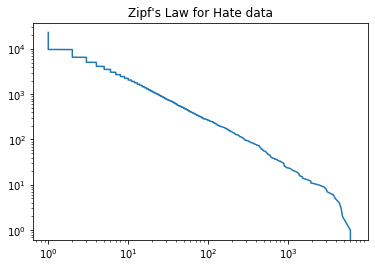

In [33]:
# zipfs law for hate
tokens_hate_df['rank'] = range(len(tokens_hate_list))
plt.plot(tokens_hate_df[1], tokens_hate_df['rank'])
plt.yscale('log')
plt.xscale('log')
plt.title("Zipf's Law for Hate data")

Text(0.5, 1.0, "Zipf's law on Sentiment data")

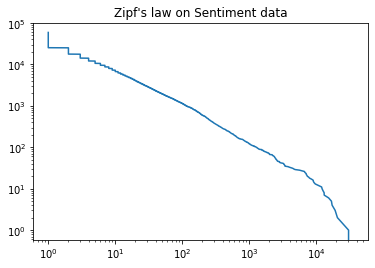

In [34]:
tokens_sentiment_df['rank'] = range(len(tokens_sentiment_list))
plt.plot(tokens_sentiment_df[1], tokens_sentiment_df['rank'])
plt.yscale('log')
plt.xscale('log')
plt.title("Zipf's law on Sentiment data")

## Task 3: Manual Annotation and Inter-Annotator Agreement

*Choose one of your two datasets. For this subtask, the emoji prediction dataset doesn’t make sense, so if that is one of your choices, pick the other one for this part of the assignment.*

Our choice of dataset: "Hate"

*In the README file in the TweetEval corpus repository, there are links to research papers from the SemEval workshop, describing how each of the datasets was created and annot- ated. Locate the one that belongs to the dataset you’ve picked for this subtask and find the passages that describe in detail how the labels for the dataset were created. Read these passages carefully.*

*Next, select a random sample of 100 tweets from the training set. Working independently from each other and without consulting the labels published in the TweetEval corpus, each member of your group should now go manually through this sample and label them according to the same scheme.*

In [38]:
Karlis_hate = [0] + open("iaa/KarlisHateOrNot.txt", "r", encoding="utf-8").read().split('\n')
Iben_hate = [0] + open("iaa/iben_map.txt", "r", encoding="utf-8").read().split('\n')
Markus_hate = [0] + open("iaa/iaa_labels_markus.txt", "r", encoding="utf-8").read().split('\n')
Ida_hate = [0] + open("iaa/LabelsHateIda.txt", "r", encoding="utf-8").read().split('\n')
correct_hate = [0] + open("iaa/iaa_labels.txt", "r", encoding="utf-8").read().split('\n')
Hate_labels = pd.DataFrame(list(zip(Karlis_hate,Iben_hate,Markus_hate,Ida_hate, correct_hate)), columns =['Karlis', 'Iben',"Markus","Ida", "Answers"])

In [39]:
for i in ['Karlis', 'Iben',"Markus","Ida", "Answers"]:
    Hate_labels[i] = Hate_labels[i].astype('int')

*Report on the inter-annotator agreement, including the agreement with the published labels, and discuss what phenomena in the data caused the biggest problems for inter-annotator agreement.*

In [40]:
# it is computing the agreement factor. 
n = 121
agree_1 = Hate_labels['Karlis'] & Hate_labels['Iben']  & Hate_labels['Markus']  & Hate_labels['Ida'] & Hate_labels['Answers']
agree_0 = (Hate_labels['Karlis'] == 0) & (Hate_labels['Iben'] == 0)  & (Hate_labels['Markus'] == 0)  & (Hate_labels['Ida'] == 0) & (Hate_labels['Answers'] == 0)
A_0 = sum(agree_1)/n + sum(agree_0)/n
print(A_0)
# expected agreement cohens kappa
columns = ['Karlis', 'Iben',"Markus","Ida", 'Answers']
k_is_1 = 1
for i in columns:
    k_is_1 = k_is_1 * (sum(Hate_labels[i])/n) # for each text, how likely it is, that they're all gonna classify it as hate speech by pure chance 
k_is_0 = 1
for i in columns:
    k_is_0 = k_is_0 * ((121 - sum(Hate_labels[i]))/n) #for each text, how likely it is, going to be classified as not hate speech, by pure chance

A_e = k_is_0 + k_is_1

agree_factor = (A_0 - A_e)/(1 - A_e)
agree_factor

0.4462809917355372


0.38440168274602066

*What phenomena in the data caused the biggest problems for inter-annotator agreement?*

ANSWER: 
- Sensitive (often political) subjects, but not hate which gave us a diversity of labels.  
- explicit language, but not hate

Agreement was mostly on misogyny and disagreement on xenophobia
- It was difficult to tell if the tweet was hateful xenophobia or just a political position.
- Whereas, there were less political positions on women and just outright hate. 

Sometime, there was hateful speech but not about the selected topics which confused us. 
We did not know if a simple hastag like #buildthatwall is hate speech but it seemed like it is.

Incidents of no hate speech but the citation had hate speech in them, this also confused us.

## Task 4: Automatic Prediction

*Finally, use scikit-learn to train a classifier for the automatic prediction of the labels in the two datasets you have chosen. During the lessons, we have not had time to discuss machine learning techniques and classification methods in detail, so in this exercise you will be using library implementations as “black box” methods.* <br>

*Run all classification experiments on both of the tasks you’ve chosen (one binary and one multi-class task). Evaluate your different classifiers on the validation set and report relevant evaluation metrics (accuracy, precision/recall/F-score).* <br>

*As a baseline, start with the sklearn.linear_model.SGDClassifier in a logistic regression configuration (loss=’log’) using bag of words features. Then run at least additional experiments trying to improve your initial scores by any means you can think of. Try out at least 4 different methods. Usually you will need to run several experiments for each methods to test different parameter values. Here are some settings in scikit-learn that you could experiment with:*

*• The classification SGDClassifier.* <br>


In [41]:
def evaluate(clf, X_train, y_train, X_val, y_val):
    train_prediction = clf.predict(X_train)
    train_accuracy = metrics.accuracy_score(y_train, train_prediction)
    train_precision = metrics.precision_score(y_train, train_prediction)
    train_recall = metrics.recall_score(y_train, train_prediction)
    train_f1 = metrics.f1_score(y_train, train_prediction)

    test_prediction = clf.predict(X_val)
    test_accuracy = metrics.accuracy_score(y_val, test_prediction)
    test_precision = metrics.precision_score(y_val, test_prediction)
    test_recall = metrics.recall_score(y_val, test_prediction)
    test_f1 = metrics.f1_score(y_val, test_prediction)


    print('Validations of predictions made based on all features, using KNN:')
    print('Metric\t\ttraining\t\t\tvalidation')
    print(f'Accuracy\t{train_accuracy}\t\t{test_accuracy}')
    print(f'precision\t{train_precision}\t\t{test_precision}')
    print(f'recall\t\t{train_recall}\t\t{test_recall}')
    print(f'f1 Score\t{train_f1}\t\t{test_f1}')



In [48]:
def PRCurve(clf,X_val,y_val): 
    y_score = clf.decision_function(X_val) 
    average_precision = metrics.average_precision_score(y_val, y_score)

    disp = metrics.plot_precision_recall_curve(clf, X_val, y_val)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                    'AP={0:0.2f}'.format(average_precision))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80      1036
           1       0.77      0.62      0.68       764

    accuracy                           0.76      1800
   macro avg       0.76      0.74      0.74      1800
weighted avg       0.76      0.76      0.75      1800



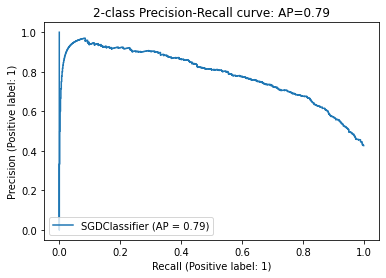

In [43]:
#(snetence,word) : frequency of word | is that it?
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x)
X = cv.fit_transform(df_hate['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_hate['label'], test_size=0.2, random_state=42)

clf = SGDClassifier(loss='log',random_state=42)
clf.fit(X_train, y_train)

print(metrics.classification_report(y_val, clf.predict(X_val)))
PRCurve(clf,X_val,y_val)

              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1036
           1       0.80      0.62      0.70       764

    accuracy                           0.77      1800
   macro avg       0.78      0.75      0.76      1800
weighted avg       0.78      0.77      0.77      1800



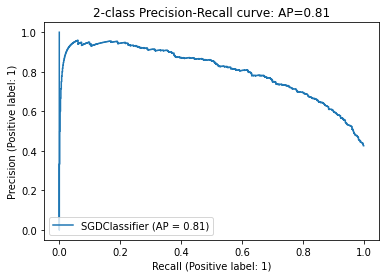

In [49]:

cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x)
X = cv.fit_transform(df_hate['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_hate['label'], test_size=0.2, random_state=42)

clf = SGDClassifier(loss='log',random_state=42, alpha=0.0005)
clf.fit(X_train, y_train)

print(metrics.classification_report(y_val, clf.predict(X_val)))
PRCurve(clf,X_val,y_val)

In [50]:
alpha_level=np.logspace(-7, 1, base=10)
#alpha_level

array([1.00000000e-07, 1.45634848e-07, 2.12095089e-07, 3.08884360e-07,
       4.49843267e-07, 6.55128557e-07, 9.54095476e-07, 1.38949549e-06,
       2.02358965e-06, 2.94705170e-06, 4.29193426e-06, 6.25055193e-06,
       9.10298178e-06, 1.32571137e-05, 1.93069773e-05, 2.81176870e-05,
       4.09491506e-05, 5.96362332e-05, 8.68511374e-05, 1.26485522e-04,
       1.84206997e-04, 2.68269580e-04, 3.90693994e-04, 5.68986603e-04,
       8.28642773e-04, 1.20679264e-03, 1.75751062e-03, 2.55954792e-03,
       3.72759372e-03, 5.42867544e-03, 7.90604321e-03, 1.15139540e-02,
       1.67683294e-02, 2.44205309e-02, 3.55648031e-02, 5.17947468e-02,
       7.54312006e-02, 1.09854114e-01, 1.59985872e-01, 2.32995181e-01,
       3.39322177e-01, 4.94171336e-01, 7.19685673e-01, 1.04811313e+00,
       1.52641797e+00, 2.22299648e+00, 3.23745754e+00, 4.71486636e+00,
       6.86648845e+00, 1.00000000e+01])

In [51]:
#alpha_level=[0.000001,0.001,0.00002]
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x)
X = cv.fit_transform(df_hate['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_hate['label'], test_size=0.2, random_state=42)

f1_scores = []
for i in alpha_level:
    clf = SGDClassifier(loss='log', alpha=i, random_state=42)
    clf.fit(X_train, y_train)
    f1_scores.append(metrics.f1_score(y_val ,clf.predict(X_val)))


Text(0, 0.5, 'f1 score')

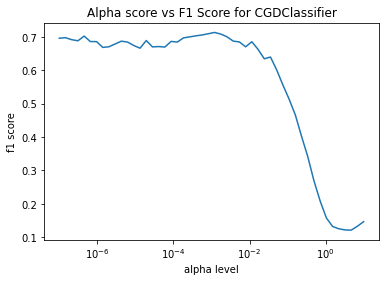

In [52]:
plt.plot(alpha_level, f1_scores)
plt.xscale('log')
plt.title("Alpha score vs F1 Score for CGDClassifier")
plt.xlabel("alpha level")
plt.ylabel("f1 score")
#ida can you get thhis and put it in the overleaf - yes

              precision    recall  f1-score   support

           0       0.77      0.87      0.82      1036
           1       0.78      0.65      0.71       764

    accuracy                           0.78      1800
   macro avg       0.78      0.76      0.76      1800
weighted avg       0.78      0.78      0.77      1800



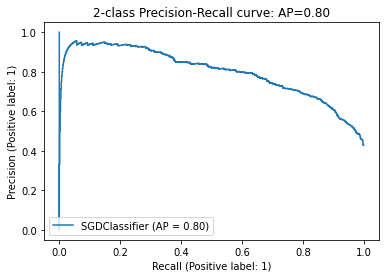

In [53]:
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x, ngram_range= (1,2))
X = cv.fit_transform(df_hate['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_hate['label'], test_size=0.2, random_state=42)

clf = SGDClassifier(loss='log', random_state=42)
clf.fit(X_train, y_train)

print(metrics.classification_report(y_val, clf.predict(X_val)))
PRCurve(clf,X_val,y_val)

In [54]:
X.shape

(9000, 139880)

*• Count transformations (sklearn.feature_extraction.text.TfIdfTransformer).* <br>


In [55]:
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x)
X = cv.fit_transform(df_hate['tokenized'])
TF=TfidfTransformer()
T = TF.fit_transform(X)
X=T


              precision    recall  f1-score   support

           0       0.75      0.90      0.82      1036
           1       0.82      0.60      0.69       764

    accuracy                           0.77      1800
   macro avg       0.79      0.75      0.76      1800
weighted avg       0.78      0.77      0.77      1800



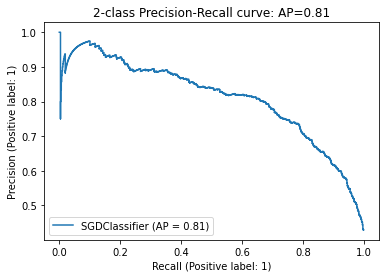

In [59]:
X_train, X_val, y_train, y_val = train_test_split(T, df_hate['label'], test_size=0.2, random_state=42)
clf = SGDClassifier(loss='log',random_state=42)
clf.fit(X_train, y_train)

print(metrics.classification_report(y_val, clf.predict(X_val)))

PRCurve(clf,X_val,y_val)

*• The classification loss(lossparametertoSGDClassifier).* <br>


              precision    recall  f1-score   support

           0       0.75      0.90      0.82      1036
           1       0.82      0.60      0.69       764

    accuracy                           0.77      1800
   macro avg       0.79      0.75      0.76      1800
weighted avg       0.78      0.77      0.77      1800



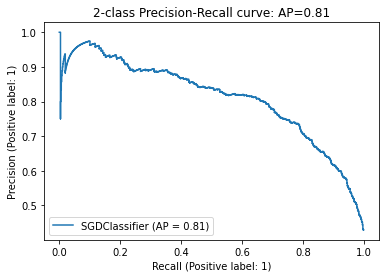

In [57]:
X_train, X_val, y_train, y_val = train_test_split(T, df_hate['label'], test_size=0.2, random_state=42)

clf = SGDClassifier(loss="log", random_state=42)
clf.fit(X_train, y_train)

print(metrics.classification_report(y_val, clf.predict(X_val)))

PRCurve(clf,X_val,y_val)

• Different classifiers 
sklearn.naive_bayes.MultinomialNB.

In [58]:
# plot of multinomialNB
#alpha_level=np.logspace(-7, 10, base=10)
alpha_level=np.arange(0,5, 0.1)


cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x)
X = cv.fit_transform(df_hate['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_hate['label'], test_size=0.2, random_state=42)


f1_scores = []
for i in alpha_level:
    clf = MultinomialNB(alpha=i)
    clf.fit(X_train, y_train)
    f1_scores.append(metrics.f1_score(y_val ,clf.predict(X_val)))


/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/naive_bayes.py:509: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Text(0, 0.5, 'f1 score')

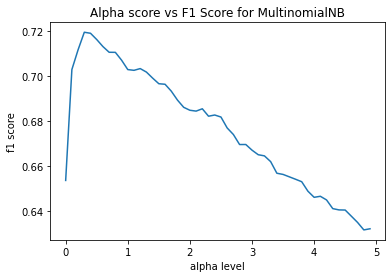

In [60]:
plt.plot(alpha_level, f1_scores)
#plt.xscale('log')
plt.title("Alpha score vs F1 Score for MultinomialNB")
plt.xlabel("alpha level")
plt.ylabel("f1 score")

In [61]:
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x)
X = cv.fit_transform(df_hate['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_hate['label'], test_size=0.2, random_state=42)

clf = MultinomialNB(alpha=0.52)
clf.fit(X_train, y_train)

print(metrics.classification_report(y_val, clf.predict(X_val)))


              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1036
           1       0.70      0.73      0.72       764

    accuracy                           0.75      1800
   macro avg       0.75      0.75      0.75      1800
weighted avg       0.76      0.75      0.75      1800



In [62]:


cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x, ngram_range=(1,2))
X = cv.fit_transform(df_hate['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_hate['label'], test_size=0.2, random_state=42)

clf = MultinomialNB(alpha=1)
clf.fit(X_train, y_train)

print(metrics.classification_report(y_val, clf.predict(X_val)))



              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1036
           1       0.73      0.75      0.74       764

    accuracy                           0.77      1800
   macro avg       0.77      0.77      0.77      1800
weighted avg       0.78      0.77      0.77      1800



Naives Bayes with TfidfTransformers

In [63]:
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x)
X = cv.fit_transform(df_hate['tokenized'])
TF=TfidfTransformer()
T = TF.fit_transform(X)
X=T

X_train, X_val, y_train, y_val = train_test_split(X, df_hate['label'], test_size=0.2, random_state=42)

clf = MultinomialNB()
clf.fit(X_train, y_train)

print(metrics.classification_report(y_val, clf.predict(X_val)))


              precision    recall  f1-score   support

           0       0.70      0.94      0.80      1036
           1       0.85      0.45      0.59       764

    accuracy                           0.73      1800
   macro avg       0.77      0.69      0.69      1800
weighted avg       0.76      0.73      0.71      1800



• Different classifiers sklearn.ensemble.RandomForestClassifier

In [64]:
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x, ngram_range= (1,2))
X = cv.fit_transform(df_hate['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_hate['label'], test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

print(metrics.classification_report(y_val, clf.predict(X_val)))


              precision    recall  f1-score   support

           0       0.72      0.93      0.81      1036
           1       0.83      0.51      0.63       764

    accuracy                           0.75      1800
   macro avg       0.78      0.72      0.72      1800
weighted avg       0.77      0.75      0.73      1800



In [65]:
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x)
X = cv.fit_transform(df_hate['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_hate['label'], test_size=0.2, random_state=42)


clf = RandomForestClassifier(30)
clf.fit(X_train, y_train)
print(metrics.classification_report(y_val, clf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.73      0.91      0.81      1036
           1       0.81      0.55      0.66       764

    accuracy                           0.76      1800
   macro avg       0.77      0.73      0.73      1800
weighted avg       0.77      0.76      0.75      1800



In [66]:

cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x)
X = cv.fit_transform(df_hate['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_hate['label'], test_size=0.2, random_state=42)


clf = RandomForestClassifier(100,random_state=42)
clf.fit(X_train, y_train)
print(metrics.classification_report(y_val, clf.predict(X_val)))


              precision    recall  f1-score   support

           0       0.74      0.92      0.82      1036
           1       0.83      0.56      0.67       764

    accuracy                           0.76      1800
   macro avg       0.78      0.74      0.74      1800
weighted avg       0.78      0.76      0.75      1800



In [67]:
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x)
X = cv.fit_transform(df_hate['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_hate['label'], test_size=0.2, random_state=42)


clf = RandomForestClassifier(200,random_state=42)
clf.fit(X_train, y_train)
print(metrics.classification_report(y_val, clf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.75      0.92      0.83      1036
           1       0.85      0.57      0.69       764

    accuracy                           0.78      1800
   macro avg       0.80      0.75      0.76      1800
weighted avg       0.79      0.78      0.77      1800



In [68]:
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x, ngram_range=(1,2))
X = cv.fit_transform(df_hate['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_hate['label'], test_size=0.2, random_state=42)


clf = RandomForestClassifier(200,random_state=42)
clf.fit(X_train, y_train)
print(metrics.classification_report(y_val, clf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.72      0.93      0.81      1036
           1       0.85      0.52      0.64       764

    accuracy                           0.75      1800
   macro avg       0.78      0.72      0.73      1800
weighted avg       0.77      0.75      0.74      1800



This is the image of the F1 socre against Number of trees for RandomForest Classifier
![Picture title](image-20210603-074019.png)

• Anything else discussed during the lessons, or implemented in scikit-learn. (TruncatedSVD)


*(For the systems that achieves the highest accuracy on the validation set, run the evaluation on the test set and report your results. We will share an anonymous overview of the test set scores of all groups after the reports are handed in.)*

## Sentiment

In [69]:
#  SDGClass
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x)
X = cv.fit_transform(df_sentiment['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_sentiment['label'], test_size=0.2, random_state=42)

clf = SGDClassifier("log", random_state=42)
clf.fit(X_train, y_train)

print(metrics.classification_report(y_val, clf.predict(X_val)))
#PRCurve(clf,X_val,y_val)
y_score = clf.decision_function(X_val)


              precision    recall  f1-score   support

           0       0.59      0.37      0.46      1379
           1       0.63      0.77      0.70      4112
           2       0.73      0.65      0.68      3632

    accuracy                           0.66      9123
   macro avg       0.65      0.60      0.61      9123
weighted avg       0.66      0.66      0.66      9123



In [70]:
alpha_level=np.logspace(-7, 1, base=10)
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x)
X = cv.fit_transform(df_sentiment['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_sentiment['label'], test_size=0.2, random_state=42)

f1_scores = []
for i in alpha_level:
    clf = SGDClassifier(loss='log', alpha=i, random_state=42)
    clf.fit(X_train, y_train)
    f1_scores.append(metrics.f1_score(y_val ,clf.predict(X_val), average='weighted'))

Text(0, 0.5, 'f1 score')

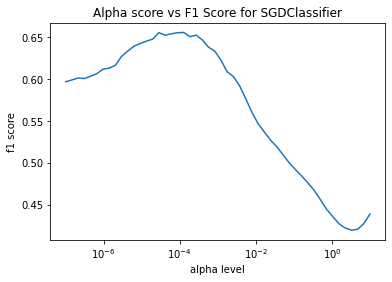

In [71]:
plt.plot(alpha_level, f1_scores)
plt.xscale('log')
plt.title("Alpha score vs F1 Score for SGDClassifier")
plt.xlabel("alpha level")
plt.ylabel("f1 score")

In [72]:
#SDGClass optimal alpha level
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x)
X = cv.fit_transform(df_sentiment['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_sentiment['label'], test_size=0.2, random_state=42)

clf = SGDClassifier(loss='log', random_state=42, alpha=0.0001)
clf.fit(X_train, y_train)

print(metrics.classification_report(y_val, clf.predict(X_val)))
#PRCurve(clf,X_val,y_val)

              precision    recall  f1-score   support

           0       0.59      0.37      0.46      1379
           1       0.63      0.77      0.70      4112
           2       0.73      0.65      0.68      3632

    accuracy                           0.66      9123
   macro avg       0.65      0.60      0.61      9123
weighted avg       0.66      0.66      0.66      9123



In [73]:
#SDGClass ngram
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x, ngram_range= (1,2))
X = cv.fit_transform(df_sentiment['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_sentiment['label'], test_size=0.2, random_state=42)

clf = SGDClassifier(loss='log', random_state=42)
clf.fit(X_train, y_train)

print(metrics.classification_report(y_val, clf.predict(X_val)))
#PRCurve(clf,X_val,y_val)

              precision    recall  f1-score   support

           0       0.60      0.35      0.44      1379
           1       0.64      0.76      0.69      4112
           2       0.71      0.67      0.69      3632

    accuracy                           0.66      9123
   macro avg       0.65      0.59      0.61      9123
weighted avg       0.66      0.66      0.65      9123



In [74]:
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x)
X = cv.fit_transform(df_sentiment['tokenized'])
TF=TfidfTransformer()
T = TF.fit_transform(X)
X=T


In [75]:
# SDGClassifier with TfidfTransformer
X_train, X_val, y_train, y_val = train_test_split(T, df_sentiment['label'], test_size=0.2, random_state=42)
clf = SGDClassifier(loss='log',random_state=42)
clf.fit(X_train, y_train)

print(metrics.classification_report(y_val, clf.predict(X_val)))

#PRCurve(clf,X_val,y_val)

              precision    recall  f1-score   support

           0       0.60      0.13      0.21      1379
           1       0.60      0.79      0.68      4112
           2       0.69      0.64      0.66      3632

    accuracy                           0.63      9123
   macro avg       0.63      0.52      0.52      9123
weighted avg       0.64      0.63      0.60      9123



In [76]:
# log loss SDGClass
X_train, X_val, y_train, y_val = train_test_split(T, df_sentiment['label'], test_size=0.2, random_state=42)

clf = SGDClassifier(loss="log", random_state=42)
clf.fit(X_train, y_train)

print(metrics.classification_report(y_val, clf.predict(X_val)))

#PRCurve(clf,X_val,y_val)

              precision    recall  f1-score   support

           0       0.60      0.13      0.21      1379
           1       0.60      0.79      0.68      4112
           2       0.69      0.64      0.66      3632

    accuracy                           0.63      9123
   macro avg       0.63      0.52      0.52      9123
weighted avg       0.64      0.63      0.60      9123



In [77]:
# MultinomialNB
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x)
X = cv.fit_transform(df_sentiment['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_sentiment['label'], test_size=0.2, random_state=42)

clf = MultinomialNB()
clf.fit(X_train, y_train)

print(metrics.classification_report(y_val, clf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.54      0.32      0.41      1379
           1       0.65      0.66      0.65      4112
           2       0.65      0.73      0.69      3632

    accuracy                           0.64      9123
   macro avg       0.61      0.57      0.58      9123
weighted avg       0.63      0.64      0.63      9123



In [78]:
#MultinomialNB with TFidfTransformer
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x)
X = cv.fit_transform(df_sentiment['tokenized'])
TF=TfidfTransformer()
T = TF.fit_transform(X)
X=T

X_train, X_val, y_train, y_val = train_test_split(X, df_sentiment['label'], test_size=0.2, random_state=42)

clf = MultinomialNB()
clf.fit(X_train, y_train)

print(metrics.classification_report(y_val, clf.predict(X_val)))


              precision    recall  f1-score   support

           0       0.83      0.00      0.01      1379
           1       0.58      0.83      0.68      4112
           2       0.70      0.61      0.65      3632

    accuracy                           0.62      9123
   macro avg       0.70      0.48      0.45      9123
weighted avg       0.66      0.62      0.57      9123



In [79]:
#RandomForestClassifier 
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x)
X = cv.fit_transform(df_sentiment['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_sentiment['label'], test_size=0.2, random_state=42)


clf = RandomForestClassifier(100,random_state=42)
clf.fit(X_train, y_train)
print(metrics.classification_report(y_val, clf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.76      0.06      0.12      1379
           1       0.58      0.83      0.68      4112
           2       0.69      0.60      0.64      3632

    accuracy                           0.62      9123
   macro avg       0.68      0.50      0.48      9123
weighted avg       0.65      0.62      0.58      9123



In [80]:
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x, ngram_range=(1,2))
X = cv.fit_transform(df_sentiment['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_sentiment['label'], test_size=0.2, random_state=42)


clf = RandomForestClassifier(100,random_state=42)
clf.fit(X_train, y_train)
print(metrics.classification_report(y_val, clf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.85      0.04      0.09      1379
           1       0.56      0.86      0.68      4112
           2       0.72      0.54      0.61      3632

    accuracy                           0.61      9123
   macro avg       0.71      0.48      0.46      9123
weighted avg       0.67      0.61      0.56      9123



## Run it on test data.

In [82]:
#training it in the same manner as before

cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x, ngram_range=(1,2))
X = cv.fit_transform(df_hate['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_hate['label'], test_size=0.2, random_state=42)

clf = MultinomialNB(alpha=1)
clf.fit(X_train, y_train)

# making matrix of test data
X_test = cv.transform(test_hate['tokenized'])

# predicting test labels based on said matric, using our model

#clf.predict(X_test)
print(metrics.classification_report(test_hate['label'], clf.predict(X_test)))


              precision    recall  f1-score   support

           0       0.74      0.26      0.39      1718
           1       0.46      0.87      0.60      1252

    accuracy                           0.52      2970
   macro avg       0.60      0.57      0.50      2970
weighted avg       0.62      0.52      0.48      2970



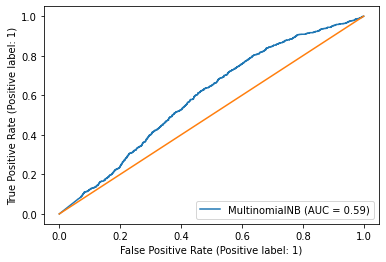

In [84]:
metrics.plot_roc_curve(clf, X_test,test_hate['label'])
plt.plot([0,1],[0,1])

In [95]:
# Machine Learning for sentiment data using our best model SGDClassifier with loss="log"
cv = CountVectorizer(tokenizer=lambda x: x, preprocessor= lambda x: x)
X = cv.fit_transform(df_sentiment['tokenized'])

X_train, X_val, y_train, y_val = train_test_split(X, df_sentiment['label'], test_size=0.2, random_state=42)

clf = SGDClassifier(loss="log")
clf.fit(X_train, y_train)

# making matrix of test data
X_test = cv.transform(test_sentiment['tokenized'])

# predicting test labels based on said matric, using our model

#clf.predict(X_test)
print(metrics.classification_report(test_sentiment['label'], clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.72      0.24      0.36      3972
           1       0.57      0.81      0.67      5937
           2       0.51      0.54      0.52      2375

    accuracy                           0.58     12284
   macro avg       0.60      0.53      0.52     12284
weighted avg       0.61      0.58      0.54     12284



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5235cf77-d347-437f-a336-60ef81766ce7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>